In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, clean_ticks, savefig
import pandas as pd

import os
import seaborn as sns
import numpy as np

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]

# Load in raw data and normalize

In [5]:
feedback_df = pd.read_parquet(
    os.path.join(
        raw_dirs["closed_loop_behavior"],
        "closed_loop_behavior_velocity_conditioned.parquet",
    )
)

In [6]:
meta_df = feedback_df.drop_duplicates("uuid")

In [8]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    display(
        meta_df.groupby("mouse_id")["date"].apply(
            lambda x: x.dt.strftime("%D").unique()
        )
    )

mouse_id
5891            [02/23/22, 02/24/22, 02/28/22, 03/01/22, 03/02/22, 03/03/22, 03/04/22, 03/07/22, 03/08/22, 03/09/22]
5892            [02/23/22, 02/24/22, 02/28/22, 03/01/22, 03/02/22, 03/03/22, 03/04/22, 03/07/22, 03/08/22, 03/09/22]
5893            [02/23/22, 02/24/22, 02/28/22, 03/01/22, 03/02/22, 03/03/22, 03/04/22, 03/07/22, 03/08/22, 03/09/22]
5894            [02/23/22, 02/24/22, 02/28/22, 03/01/22, 03/02/22, 03/03/22, 03/04/22, 03/07/22, 03/08/22, 03/09/22]
dls-ai32jr-1                                                      [10/27/21, 10/28/21, 10/29/21, 11/01/21, 11/02/21]
dls-ai32jr-2                                                      [10/27/21, 10/28/21, 10/29/21, 11/01/21, 11/02/21]
dls-ai32jr-3                                                      [10/27/21, 10/28/21, 10/29/21, 11/01/21, 11/02/21]
dls-ai32jr-4                                                      [10/27/21, 10/28/21, 10/29/21, 11/01/21, 11/02/21]
dls-ai32jr-5                                           

In [9]:
meta_df = feedback_df.drop_duplicates(["syllable_group", "date"])

In [10]:
cnts = meta_df.groupby(["mouse_id", "stim_duration", "target_syllable"])[
    "syllable_group"
].nunique()

## Now average velocity for all syllables

In [12]:
scalar_keys = [
    "velocity_2d_mm",
    "acceleration_2d_mm",
    "velocity_angle",
    "velocity_height",
]
scalar_keys = feedback_df.columns.intersection(scalar_keys).tolist()

## Analyze in RLE space

In [13]:
feedback_df["syllable_number"] = feedback_df.groupby("uuid")[
    "predicted_syllable"
].apply(lambda x: (x.diff() != 0).cumsum())
feedback_df["feedback_bool"] = (feedback_df["session_number"].isin([1, 2])) & (
    feedback_df["feedback_status"] == 1
)
feedback_df["catch_bool"] = (feedback_df["session_number"].isin([1, 2])) & (
    feedback_df["feedback_status"] == 0
)
try:
    feedback_df["sim_feedback_bool"] = feedback_df["sim_feedback_status target_20"] == 1
except KeyError:
    pass

/tmp/ipykernel_1567289/1305843912.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ].apply(lambda x: (x.diff() != 0).cumsum())


In [14]:
# we can drop dupes
rle_df = feedback_df.drop_duplicates(["uuid", "syllable_number"]).set_index(
    ["uuid", "syllable_number", "predicted_syllable"]
)

# then merge in scalar_keys
scalar_df = feedback_df.groupby(
    ["uuid", "syllable_number", "predicted_syllable"], observed=True
)[scalar_keys].agg(["mean", "max", "median"])
scalar_df.columns = ["_".join(_) for _ in scalar_df.columns]

for _scalar in scalar_df.columns:
    scalar_df[f"{_scalar}_z"] = scalar_df.groupby(["uuid", "predicted_syllable"])[
        _scalar
    ].apply(lambda x: (x - x.mean()) / x.std())
    rle_df = rle_df.drop(scalar_df.columns, axis=1, errors="ignore")
rle_df = rle_df.join(scalar_df)

# then merge in stim
status_stim_df = (
    feedback_df.groupby(
        ["uuid", "syllable_number", "predicted_syllable"], observed=True
    )["feedback_bool"]
    .any()
    .rename("is_feedback")
    .astype("bool")
)
status_catch_df = (
    feedback_df.groupby(
        ["uuid", "syllable_number", "predicted_syllable"], observed=True
    )["catch_bool"]
    .any()
    .rename("is_catch")
    .astype("bool")
)

try:
    status_stim_sim_df = (
        feedback_df.groupby(
            ["uuid", "syllable_number", "predicted_syllable"], observed=True
        )["sim_feedback_bool"]
        .any()
        .rename("is_sim_feedback")
        .astype("bool")
    )
    rle_df = rle_df.join(status_stim_df).join(status_catch_df).join(status_stim_sim_df)
except KeyError:
    rle_df = rle_df.join(status_stim_df).join(status_catch_df)

/tmp/ipykernel_1567289/2225413309.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ].apply(lambda x: (x - x.mean()) / x.std())
/tmp/ipykernel_1567289/2225413309.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ].apply(lambda x: (x - x.mean()) / x.std())
/tmp/ipykernel_1567289/2225413309.

In [15]:
rle_df = rle_df.reset_index()

In [16]:
rle_df["direction"] = rle_df["trigger_syllable_scalar_comparison"].map(
    {"gt": "up", "lt": "down"}
)

In [17]:
rle_df["syllable_trial"] = 0
for _syll in tqdm(rle_df["predicted_syllable"].unique()):
    rle_df["is_syllable"] = rle_df["predicted_syllable"] == _syll
    rle_df.loc[rle_df["is_syllable"], "syllable_trial"] = rle_df.groupby("uuid")[
        "is_syllable"
    ].cumsum()

  0%|          | 0/58 [00:00<?, ?it/s]

In [18]:
rle_df["time_bin"] = pd.cut(rle_df["timestamp"], np.arange(15 * 60, 46 * 60, 5 * 60))
rle_df["plt_time_bin"] = (
    rle_df["time_bin"].apply(lambda x: x.mid.astype("float")).astype("float")
)

rle_df["is_target"] = rle_df["predicted_syllable"] == rle_df["target_syllable"]
rle_df["bin_trial"] = (
    rle_df.groupby("uuid")["is_feedback"].cumsum() * rle_df["is_feedback"]
)
rle_df["bin_trial"] += rle_df.groupby("uuid")["is_catch"].cumsum() * rle_df["is_catch"]
rle_df["bin_trial"] = rle_df["bin_trial"].replace(0, np.nan)

try:
    rle_df["sim_feedback_trial"] = (
        rle_df.groupby("uuid")["is_sim_feedback"].cumsum() * rle_df["is_sim_feedback"]
    )
except KeyError:
    pass
rle_df["feedback_trial"] = (
    rle_df.groupby("uuid")["is_feedback"].cumsum() * rle_df["is_feedback"]
)
rle_df["catch_trial"] = rle_df.groupby("uuid")["is_catch"].cumsum() * rle_df["is_catch"]

rle_df["any_trial"] = rle_df["feedback_trial"]
rle_df.loc[rle_df["is_catch"], "any_trial"] = rle_df.loc[
    rle_df["is_catch"], "catch_trial"
]

rle_df["trial_status"] = "n/a"
rle_df.loc[rle_df["is_feedback"], "trial_status"] = "feedback"
rle_df.loc[rle_df["is_catch"], "trial_status"] = "catch"

In [19]:
setup_plotting_env()

In [20]:
rle_df["uuid"] = rle_df["uuid"].astype("str")

In [21]:
threshold = 50
use_df = (
    rle_df.loc[rle_df["target_syllable"] > 0]
    .groupby("uuid")
    .filter(lambda x: x["feedback_trial"].max() > threshold)
)
use_df["date_rnd"] = use_df["date"].dt.strftime("%D")

In [22]:
start = 15 * 60
stop = 45 * 60

In [23]:
baseline_mean = (
    rle_df.loc[
        ((~rle_df["session_number"].isin([1, 2])) | (rle_df["target_syllable"] <= 0))
    ]
    .groupby(["mouse_id", "uuid"])["predicted_syllable"]
    .value_counts(normalize=True)
    .xs(20, level="predicted_syllable")
    .groupby("mouse_id")
    .mean()
)

In [24]:
baseline_sig = (
    rle_df.loc[
        ((~rle_df["session_number"].isin([1, 2])) | (rle_df["target_syllable"] <= 0))
    ]
    .groupby(["mouse_id", "uuid"])["predicted_syllable"]
    .value_counts(normalize=True)
    .xs(20, level="predicted_syllable")
    .groupby("mouse_id")
    .std()
)

In [25]:
stim = (
    rle_df.loc[
        (rle_df["session_number"].isin([1, 2]))
        & (rle_df["timestamp"].between(start, stop))
    ]
    .groupby(["mouse_id", "uuid"])["predicted_syllable"]
    .value_counts(normalize=True)
    .xs(20, level="predicted_syllable")
    .groupby("mouse_id")
    .mean()
)

In [26]:
learner_list = stim - baseline_mean
learner_list = learner_list[learner_list > 0].index

In [27]:
use_df = use_df.loc[use_df["mouse_id"].isin(learner_list)].copy()

In [28]:
group_keys = [
    "mouse_id",
    "direction",
    "session_number",
    "date_rnd",
    "target_syllable",
    "syllable_group",
    "genotype",
    "uuid",
    "feedback_trial",
]

per_trial = use_df.loc[use_df["is_feedback"]].groupby(group_keys, observed=True).mean()

scalar_keys = scalar_df.columns.tolist()
baseline_trials = 15
bin_size = 15

per_trial[scalar_keys] = per_trial.groupby(["uuid"])[scalar_keys].transform(
    lambda x: (x - x.iloc[:baseline_trials].mean())
    / (x.iloc[:baseline_trials].std() + 1e-1)
)

per_trial = per_trial[scalar_keys].melt(ignore_index=False).reset_index()
per_trial["trial_bin"] = pd.cut(
    per_trial["feedback_trial"], [_ for _ in np.arange(0, int(threshold) + 1, bin_size)]
)
per_trial["trial_bin_center"] = per_trial["trial_bin"].apply(lambda x: x.mid)

/tmp/ipykernel_1567289/2196430509.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  per_trial = use_df.loc[use_df["is_feedback"]].groupby(group_keys, observed=True).mean()


In [29]:
setup_plotting_env()
sns.set_context("paper")

In [30]:
per_trial["genotype"] = per_trial["genotype"].astype("str")

In [31]:
aliases = {
    "velocity_2d_mm_median_z": "vel.",
    "velocity_2d_mm_mean_z": "vel. b",
}

In [32]:
var_order = ["velocity_2d_mm_mean_z"]

In [33]:
setup_plotting_env()

/tmp/ipykernel_1567289/2771656835.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
/home/markowitzmeister_gmail_com/miniconda3/envs/spont-da/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  func(*plot_args, **plot_kwargs)


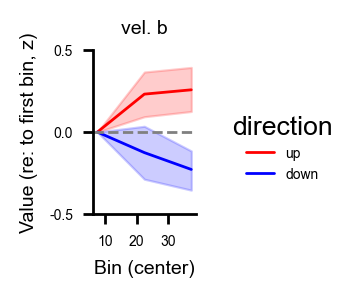

In [34]:
g = sns.relplot(
    data=per_trial.groupby(
        ["genotype", "variable", "direction", "uuid", "trial_bin_center"]
    )
    .mean()
    .reset_index(),
    x="trial_bin_center",
    y="value",
    col="variable",
    col_order=var_order,
    hue="direction",
    hue_order=["up", "down"],
    palette=["r", "b"],
    ci=68,
    height=1.5,
    aspect=0.75,
    kind="line",
    estimator=np.mean,
)
g.refline(y=0)
g.set_axis_labels("Bin (center)", "Value (re: to first bin, z)")
g.set_titles(col_template="{col_name}")
clean_ticks(g.axes.flat[0], "y", precision=1)
for ax in g.axes[0]:
    ax.set_title(aliases[ax.get_title()])
savefig(
    g.fig,
    os.path.join(figure_cfg["store_dir"], "syllable_scalar_lineplot"),
    bbox_inches="tight",
)

In [35]:
max_bin = per_trial["trial_bin_center"].max()

In [36]:
means = per_trial.groupby(
    ["genotype", "variable", "direction", "uuid", "trial_bin_center"]
).mean()

/tmp/ipykernel_1567289/906161012.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean()


In [37]:
from scipy.stats import mannwhitneyu

In [38]:
use_test = mannwhitneyu

In [39]:
stats = {}
for _var in var_order:
    pop1 = (
        means.loc[means.index.get_level_values("trial_bin_center") > 7.5]
        .xs(("up", _var), level=("direction", "variable"))["value"]
        .dropna()
        .values
    )
    pop2 = (
        means.loc[means.index.get_level_values("trial_bin_center") > 7.5]
        .xs(("down", _var), level=("direction", "variable"))["value"]
        .dropna()
        .values
    )
    stats[_var] = {}
    stat, p = mannwhitneyu(pop1, pop2)
    stats[_var]["stat"] = stat
    stats[_var]["p"] = p
    stats[_var]["n1"] = len(pop1)
    stats[_var]["n2"] = len(pop2)
    stats[_var]["n_definition"] = "Per session/bin averages"

In [40]:
with open(
    os.path.join(proc_dirs["closed_loop_behavior"], "stats_syllable_scalar.toml"), "w"
) as f:
    toml.dump(stats, f)